# Web scrapping, data cleaning dan visualisasi data

Hallo, selamat datang di tutorial python saya yang pertama kalinya mengenai pengambilan data dari internet (web scrapping), pembersihan data(cleaning) dan visualisasi data.

web scrapping menggunakan library Beautiful soup, data cleaning menggunakan perintah dasar python, dan visualisasi data menggunakan matplotlib.pyplot serta seaborn.

Tutorial ini saya jalankan menggunakan python 3.6, tidak menutup kemungkinan bisa dijalankan juga menggunakan kernel python 2.x

### Import library yang dibutuhkan

In [0]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### Memulai web scrapping dan cleaning

Pada tutorial ini kita ingin mengambil data perubahan nilai tukar mata uang  berbagai negara di dunia (khususnya terhadap USD) selama 6 bulan terakhir. Website yang menjadi target adalah https://www.exchange-rates.org. Dengan menggunakan beautifull soup,data html dapat dengan mudah diproses dan dibaca. Tutorial beautifull soup salah satunya bisa dilihat di https://www.dataquest.io/blog/web-scraping-tutorial-python/ .
Pada cell dibawah ini kita jalankan dua proses yaitu scrapping sekaligus data cleaning dengan tujuan untuk mengambil data nama negara dan kode mata uangnya.


In [0]:
continent_codes = ['A', 'P', 'E', 'M', 'F']
country_names = []
country_codes = {}
for continent_code in continent_codes:    
    home = 'https://www.exchange-rates.org/currentRates/{}/USD'.format(continent_code)
    home = requests.get(home)
    home = home.text
    soup_home_raw = BeautifulSoup(home, 'html.parser')
    soup_home = soup_home_raw.find_all('td', attrs={'class':'text-left convert-to'})
    soup_code = soup_home_raw.find_all('td', attrs={'class':'text-narrow-screen-hidden'})
    for i, x in enumerate(soup_home):
        z = x.text
        z = z.split(' ')
        currency_code = list(z[-1])[-3:]
        currency_code = "".join(currency_code)
        country_name = "_".join(z[0:-1]) +"_" + "".join(list(z[-1])[:-3])
        country_name = country_name.split('_')[1:]
        country_name = "_".join(country_name)
        country_codes[country_name] = soup_code[(i*2)+1].text.split(" ")[-1]
        
with open('country_codes.json', 'w') as f:
    json.dump(country_codes, f)

### Fungsi tambahan

Fungsi dibawah ini sebagai tambahan untuk identifikasi apakah character bisa di convert menjadi suatu angka atau tidak (fungsi is_number) dan untuk membuat 'kebalikan' cara kerja dictionary, nilai kembalian (keys()) didapat dari masukan values() (fungsi dictkeys_from_value).

In [0]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False

def dictkeys_from_value(dictio, value):
    idx_val = list(dictio.values()).index(value)
    return list(dictio.keys())[idx_val]

### Scrapping data nilai tukar mata uang

Sama seperti pada scrapping diawal, kita scrapping data dari web utama yang sama. Hasil dari scrapping ini yaitu value berformat json yang berisi nama negara, tanggal, hari dan nilai tukar mata uangnya. Jika sudah dapat kita simpan ke disc supaya bisa digunakan selanjutnya

In [0]:
results = {}
print("Progress scrapping")
for i, code in enumerate(tqdm(list(country_codes.values()))):
    tmp_data = {}
    webpage = 'https://www.exchange-rates.org/history/{}/USD/T'.format(code)
    webpage = requests.get(webpage)
    webpage = webpage.text
    soup = BeautifulSoup(webpage, 'html.parser')
    data = soup.find_all('div', attrs={'class':'table-responsive'})
    
    days = []
    currencys = []
    dates = []
    x = data[0].text[3:-3].split(" ")
    for i, y in enumerate(x[:-1]):
        if i % 5 == 0:
            tmp = []
            for i, x in enumerate(list(y.split('/2018')[-1])):
                if is_number(x) == True:
                    tmp.append(i)
            days.append((y.split('/2018')[-1])[:tmp[0]])
            tmp_curr = (y.split('/2018')[-1])[tmp[0]:tmp[-1]]
            if ',' in list(tmp_curr):
                tmp_curr = list(tmp_curr)
                tmp_curr.remove(',')
                tmp_curr = "".join(tmp_curr)
            currencys.append(float(tmp_curr))
            tmp_dates = y[:-12].split('2018')[-2].split('/')
            tmp_dates[-1] = '2018'
            tmp_dates = "/".join(tmp_dates)
            dates.append(tmp_dates)
    if len(days) != len(currencys) and len(days) != len(dates):
        print("Length days, currencys and days lists must same. got length days {}, currencys {}, dates {}".format(len(days), len(currencys), len(dates)))
        break
    else:
        tmp_data['day'] = days
        tmp_data['date'] = dates
        tmp_data['currency'] = currencys
    
    results[code] = tmp_data
    
#simpan ke file json
with open('results.json', 'w') as f:
    json.dump(results, f)

HBox(children=(IntProgress(value=0, max=127), HTML(value='')))

### Load data hasil 

Load file results dan kode negara yang telah dirapikan. Jika tidak bisa scrapping data karena tidak ada koneksi internet bisa gunakan langsung data yang sudah ada

In [0]:
#load file json
with open('results.json', 'r') as f:
    results = json.load(f)

with open('country_codes.json', 'r') as f:
    country_codes = json.load(f)

### Visualisasi data hasil.

Visualisasi pertama yaitu membuat grafik nilai tukar mata uang terhadap dolar selama 6 bulan terakhir.
Library utama menggunakan seaborn dan matplotlib.pyplot karena fungsi dasar untuk plotting data cukup lengkap dibawa oleh pyplot dan sns mempercantik tampilannya.

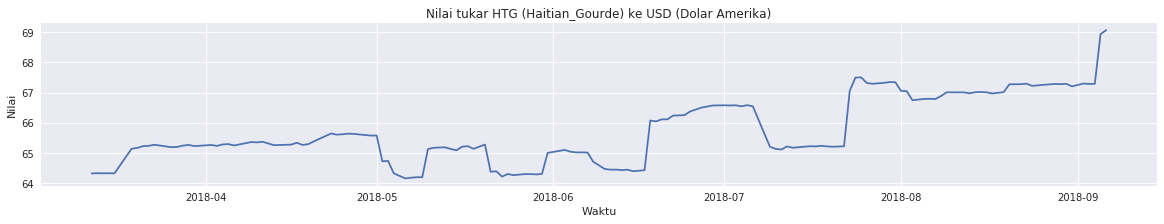

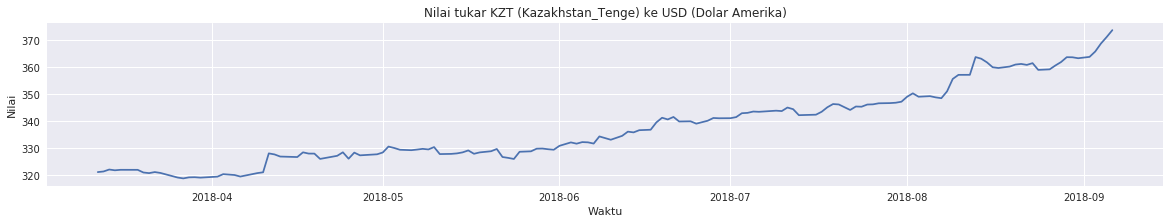

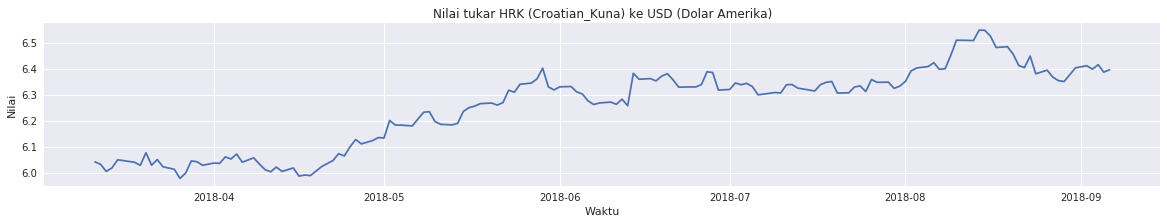

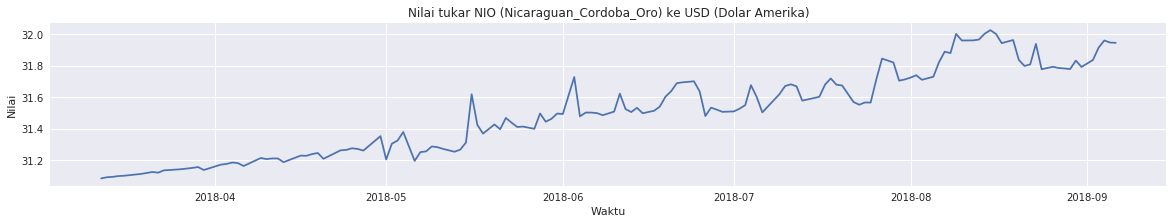

In [0]:
# plot perubahan nilai tukar mata uang sebagai fungsi waktu
for i, code in enumerate(list(results.keys())[0:4]):
    # proses ke dataframe supaya lebih mudah untuk ditampilkan ke data
    pd_data = pd.DataFrame.from_dict(results[code])
    pd_data['date'] = pd.to_datetime(pd_data['date'])
    plt.figure(figsize=(20, 3))
    plt.plot(pd_data['date'], pd_data['currency'])
    negara = dictkeys_from_value(country_codes, code)
    plt.ylabel('Nilai')
    plt.xlabel('Waktu')
    plt.title("Nilai tukar {} ({}) ke USD (Dolar Amerika)".format(code,negara))
    plt.savefig('./currency/{}_to_USD.jpg'.format(code))
    

### Merapikan data untuk plot inflasi

Selanjutnya merapikan data yang akan digunakan sebagai data plotting antara presentase  perubahan nilai tukar mata uang terhadap USD selama 6 bulan terakhir. Istilah ekonominya inflasi.

In [1]:
import pandas as pd
import json
import json
import pandas as pd
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
with open('results.json', 'r') as f:
    results = json.load(f)

with open('country_codes.json', 'r') as f:
    country_codes = json.load(f)

In [3]:
def dictkeys_from_value(dictio, value):
    idx_val = list(dictio.values()).index(value)
    return list(dictio.keys())[idx_val]

diff = {}
daftar_negara = []
daftar_perubahan = []
for i, code in enumerate(list(results.keys())):
    # proses ke dataframe supaya lebih mudah untuk ditampilkan ke data
    pd_data = pd.DataFrame.from_dict(results[code])
    daftar_negara.append(dictkeys_from_value(country_codes, code))
    daftar_perubahan.append(((list(pd_data['currency'])[0])-(list(pd_data['currency'])[-1]))/(list(pd_data['currency'])[0])*100)
    
diff["negara"] = daftar_negara
diff["perubahan"] = daftar_perubahan
diff_pd = pd.DataFrame.from_dict(diff)

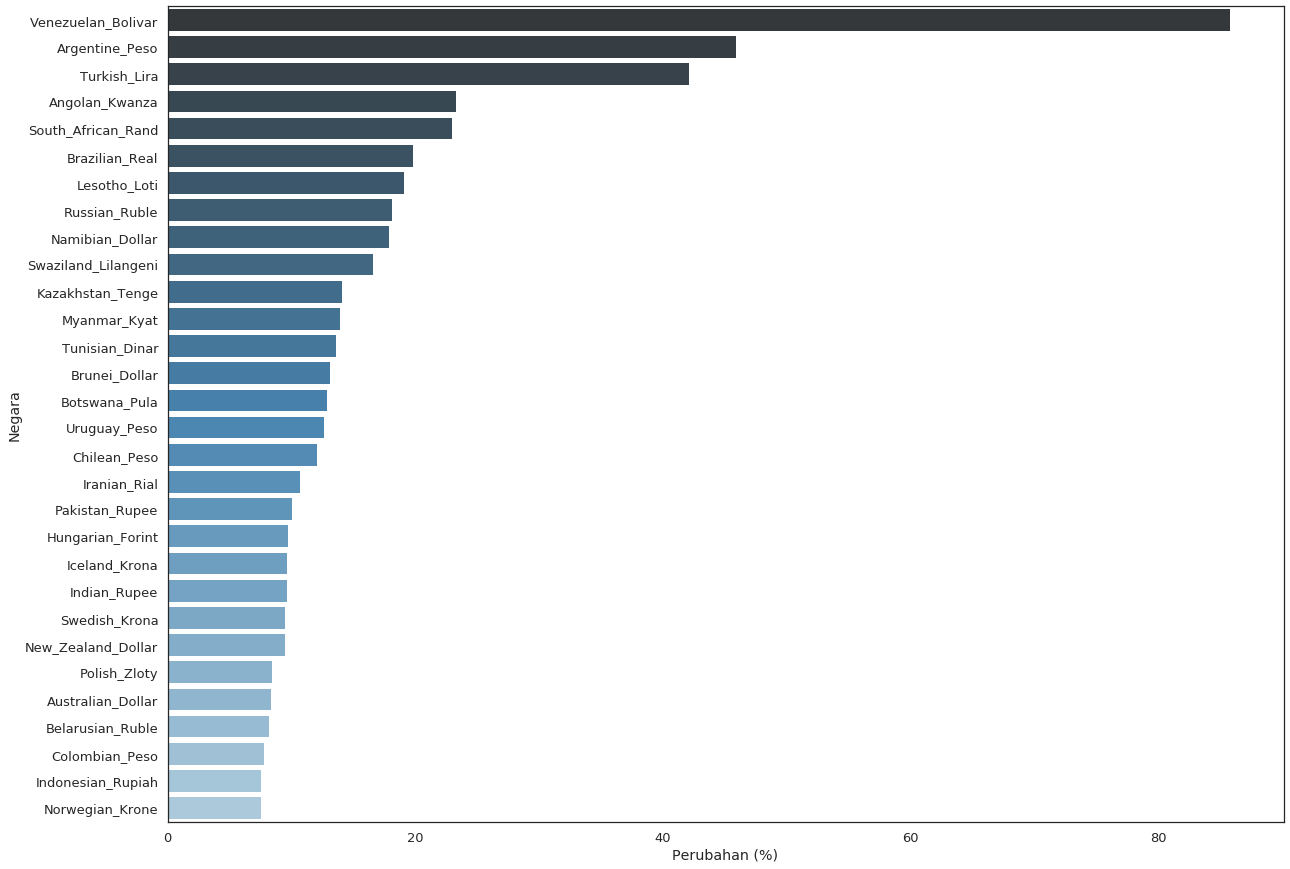

In [0]:
sort_pd = diff_pd.sort_values(by=['perubahan'], ascending=False)
sns.set(style="white", context="talk")
sort_pd = sort_pd.iloc[:30]
f, ax = plt.subplots(1, 1, figsize=(20, 15))
a = sns.barplot(x=sort_pd["perubahan"],y=sort_pd['negara'],  palette="Blues_d", ax=ax)
ax.set_xlabel("Perubahan (%)")
ax.set_ylabel("Negara")
a.get_figure().savefig("./currency/30besarlemah.jpg")

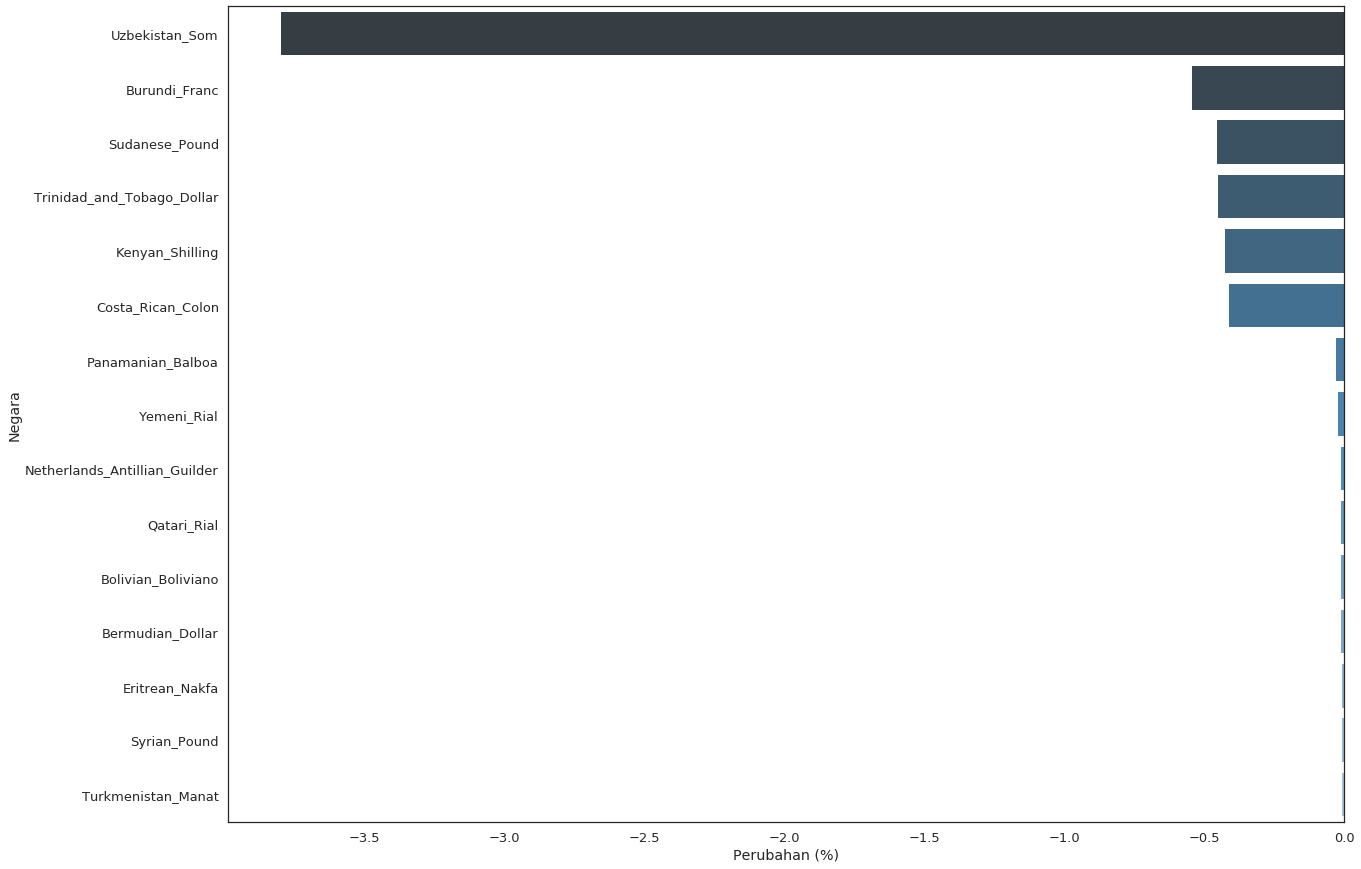

In [0]:
sort_pd = diff_pd.sort_values(by=['perubahan'])
sns.set(style="white", context="talk")
sort_pd = sort_pd.iloc[:15]
f, ax = plt.subplots(1, 1, figsize=(20, 15))
a = sns.barplot(x=sort_pd["perubahan"],y=sort_pd['negara'],  palette="Blues_d", ax=ax)
ax.set_xlabel("Perubahan (%)")
ax.set_ylabel("Negara")
a.get_figure().savefig("./currency/15besarkuat.jpg")

### Mengelompokkan berdasarkan benua untuk selanjutnya diplot berdasarkan benua 

In [0]:
continent_codes = {'A':'Amerika_Utara_dan_Selatan', 'P':'Asia_dan_Pasifik', 'E':'Eropa', 'M':'Timur_Tengah_dan_Asia_Tengah', 'F':'Afrika'}
continent_base = {}
A = []
P = []
E = []
M = []
F = []
for continent_code in continent_codes.keys():    
    home = 'https://www.exchange-rates.org/currentRates/{}/USD'.format(continent_code)
    home = requests.get(home)
    home = home.text
    soup_home_raw = BeautifulSoup(home, 'html.parser')
    soup_home = soup_home_raw.find_all('td', attrs={'class':'text-left convert-to'})
    soup_code = soup_home_raw.find_all('td', attrs={'class':'text-narrow-screen-hidden'})
    for i, x in enumerate(soup_home):
        z = x.text
        z = z.split(' ')
        currency_code = list(z[-1])[-3:]
        currency_code = "".join(currency_code)
        if continent_code == 'A':
            A.append(currency_code)
        elif continent_code == 'P':
            P.append(currency_code)
        elif continent_code == 'E':
            E.append(currency_code)
        elif continent_code == 'M':
            M.append(currency_code)
        else:
            F.append(currency_code)
continent_base[continent_codes['A']] = A
continent_base[continent_codes['P']] = P
continent_base[continent_codes['E']] = E
continent_base[continent_codes['M']] = M
continent_base[continent_codes['F']] = F


In [0]:
# plot seberapa besar perubahan dalam kurun waktu sekitar 6 bulan
# plot perubahan berdasarkan benua
curr_cont_base = {}
for cont in continent_base.keys():
    tmp_data = {}
    for x in continent_base[cont]:
        tmp_data[x] = results[x]
    curr_cont_base[cont] = tmp_data
    
diff_cont = {}
for x in curr_cont_base.keys():
    tmp_diff = curr_cont_base[x]
    tmp_diff_cont = {}
    daftar_negara = []
    daftar_perubahan = []
    for i, code in enumerate(list(tmp_diff.keys())):
        pd_data = pd.DataFrame.from_dict(tmp_diff[code])
        #print(pd_data)
        daftar_negara.append(dictkeys_from_value(country_codes, code))
        daftar_perubahan.append(((list(pd_data['currency'])[0])-(list(pd_data['currency'])[-1]))/(list(pd_data['currency'])[0])*100)    
    tmp_diff_cont["negara"] = daftar_negara
    tmp_diff_cont["perubahan"] = daftar_perubahan
    diff_cont[x] = tmp_diff_cont


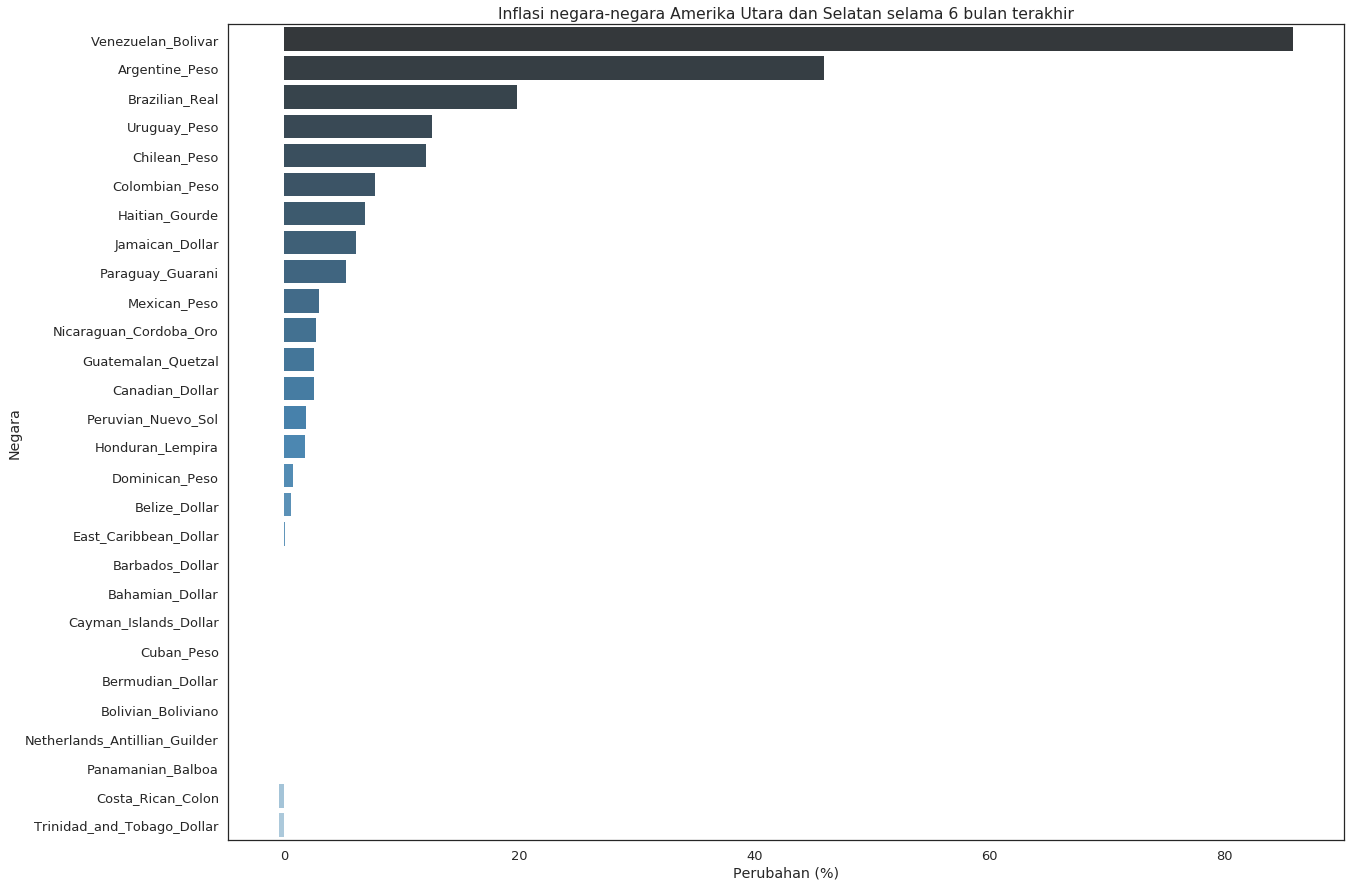

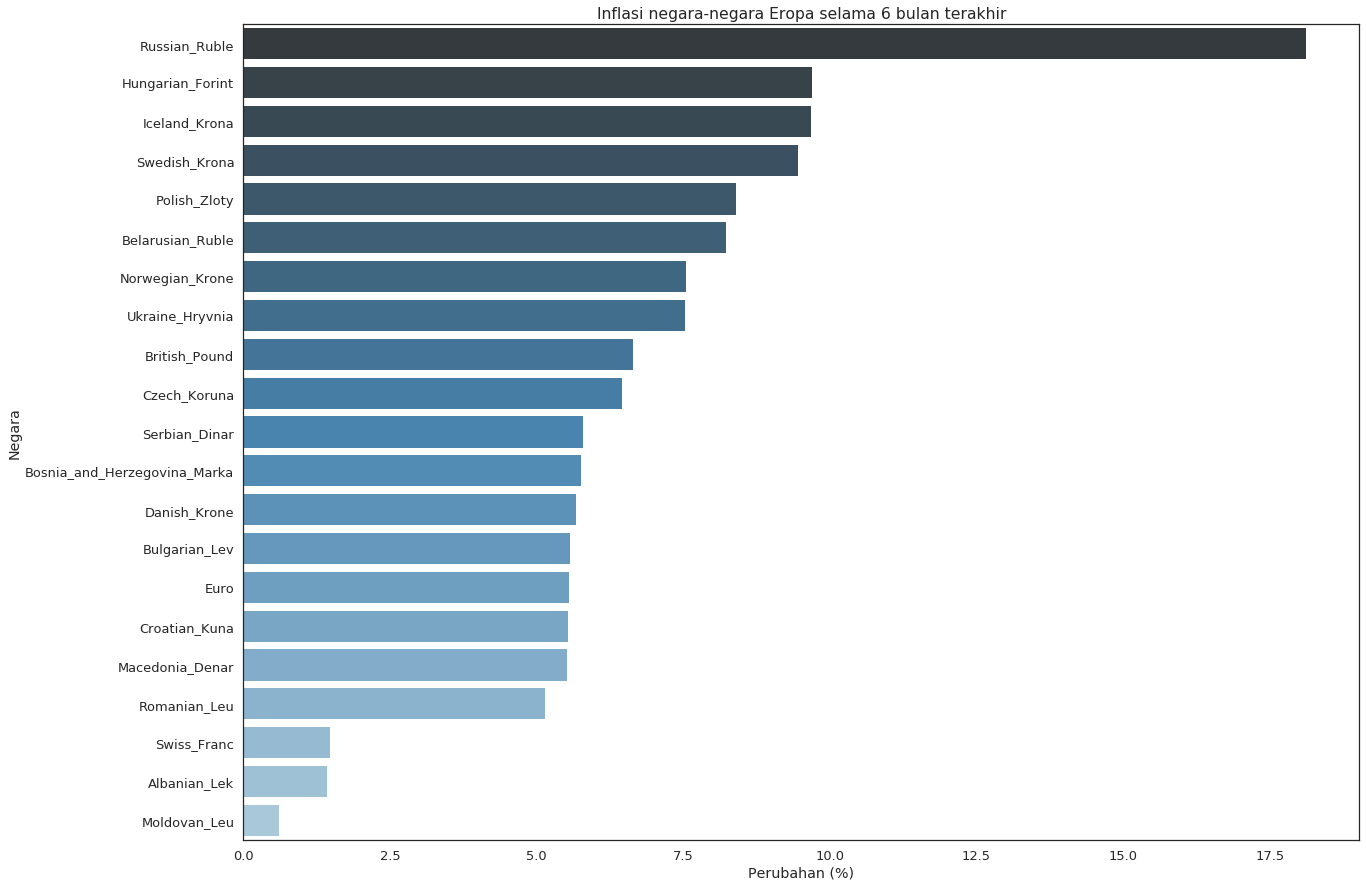

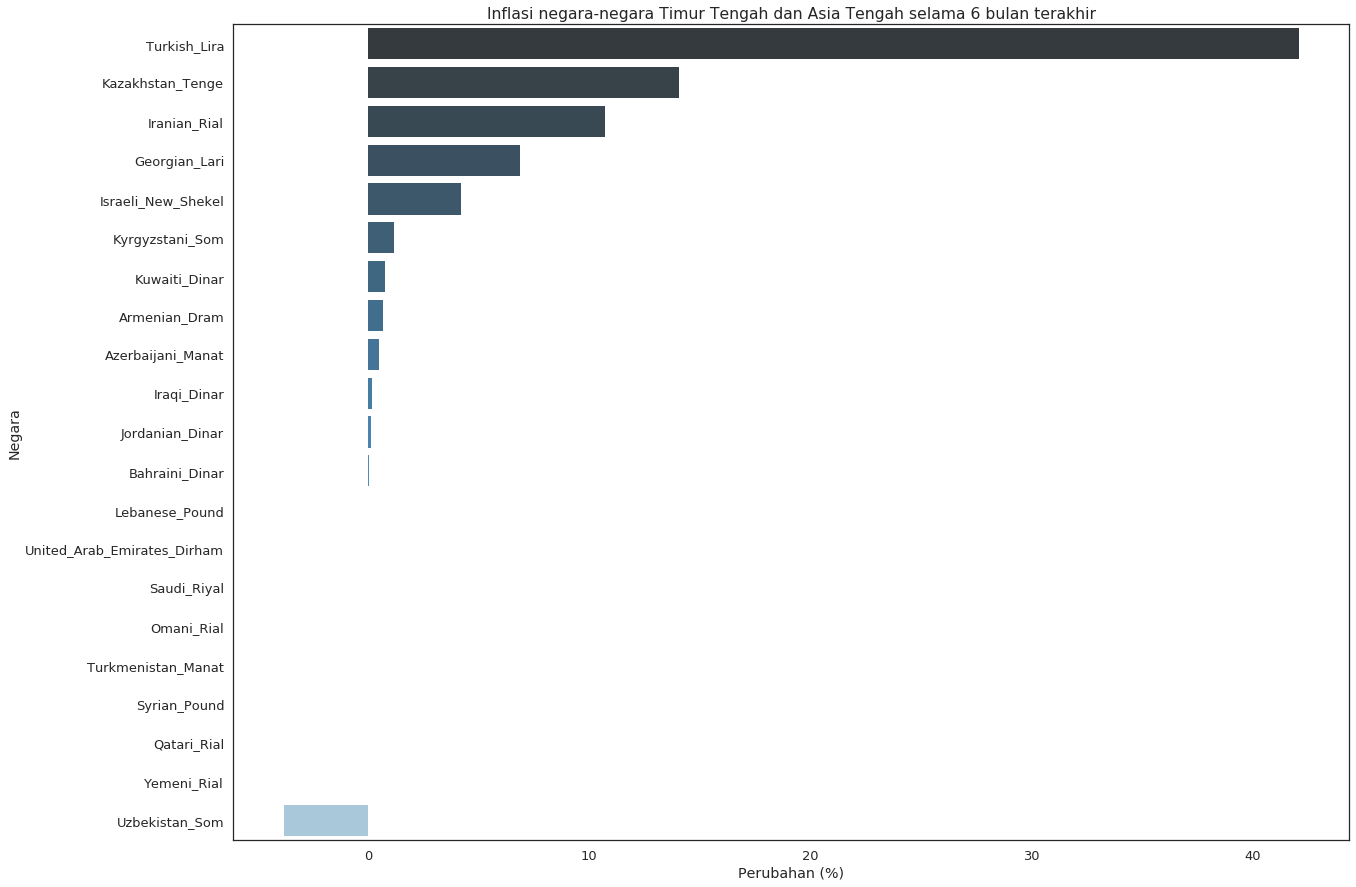

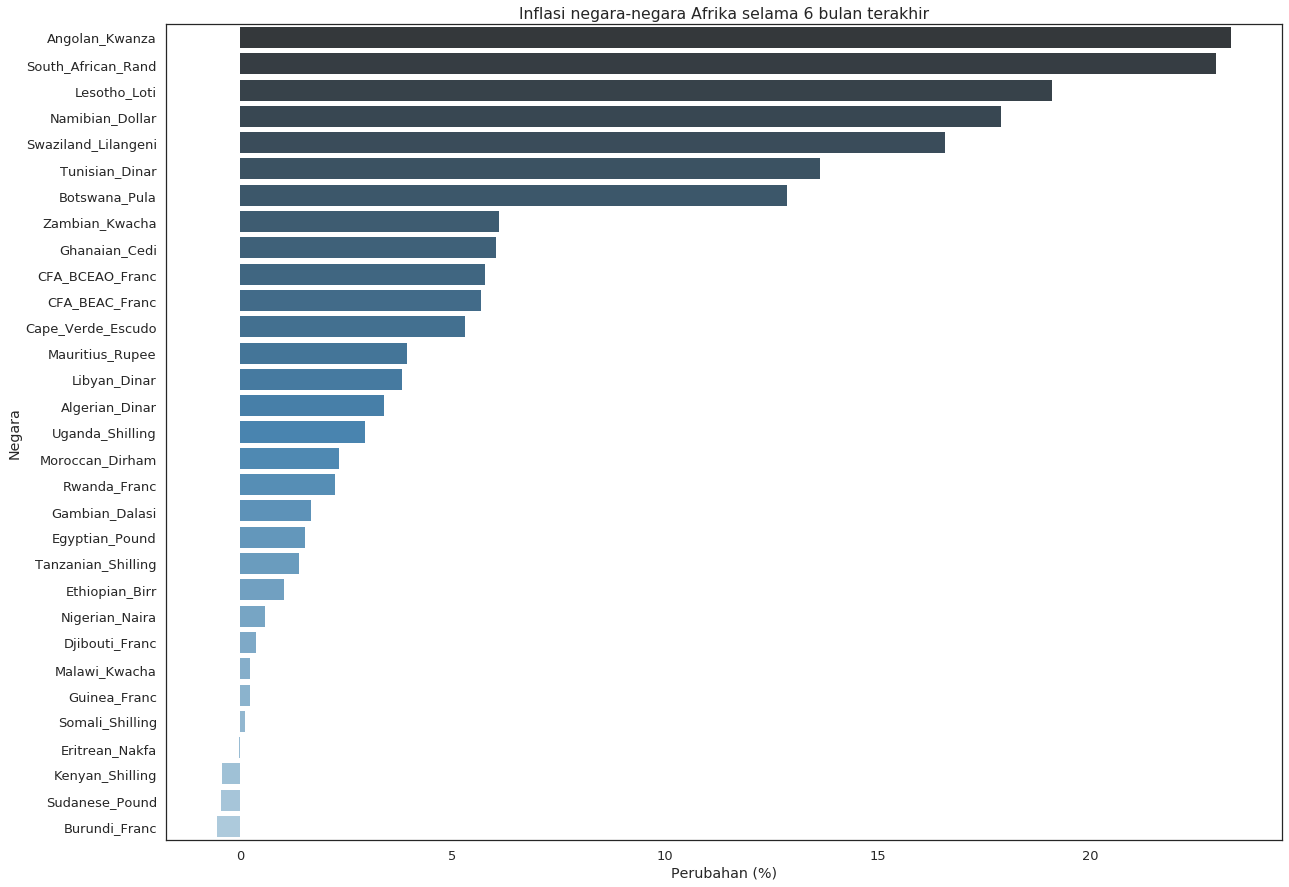

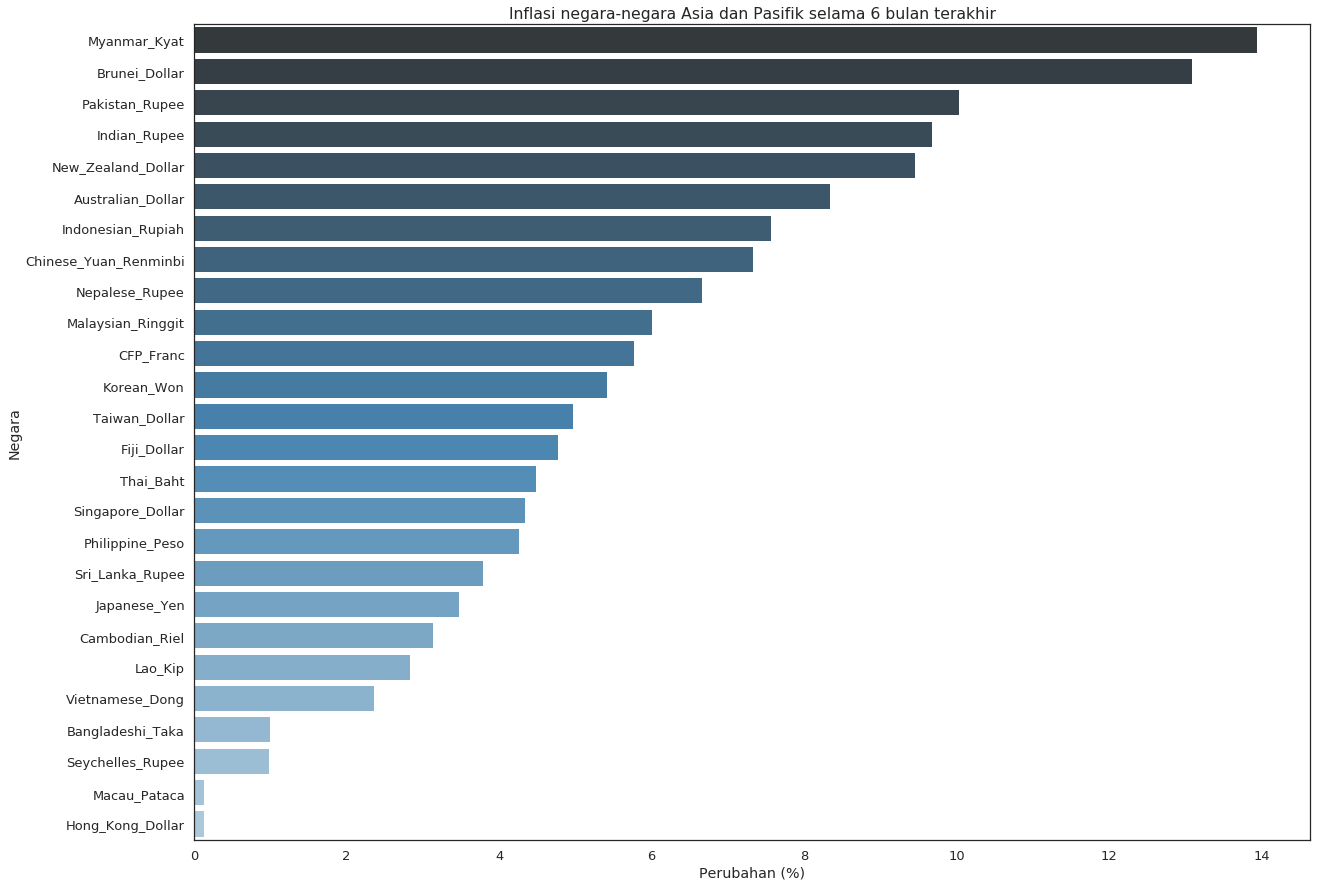

In [0]:
for x in diff_cont.keys():
    diff_cont_pd = pd.DataFrame.from_dict(diff_cont[x])
    sort_pd = diff_cont_pd.sort_values(by=['perubahan'], ascending=False)
    sns.set(style="white", context="talk")
    f, ax = plt.subplots(1, 1, figsize=(20, 15))
    a = sns.barplot(x=sort_pd["perubahan"],y=sort_pd['negara'],  palette="Blues_d", ax=ax)
    ax.set_xlabel("Perubahan (%)")
    ax.set_ylabel("Negara")
    ax.set_title("Inflasi negara-negara {} selama 6 bulan terakhir".format(" ".join(x.split('_'))))
    a.get_figure().savefig("./currency/{}.jpg".format(x))

## Terima kasih ^_^

Jika ada kritik, masukan atau saran jangan sungkan untuk hubungi khaerulumam42@gmail.com